In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from prince import MCA
import conorm
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "../../"))
sys.path.append(os.path.join(os.getcwd(), "../../nextflow"))
from pca_analysis import plot, rank_models_difference
import plotly.express as px
from gsmmutils.omics.omics_integration import OmicsIntegration 
from gsmmutils.model.COBRAmodel import MyModel
DATA_PATH = "/home/ecunha/omics-integration/data/dsalina/PRJNA437866"
RESULTS_PATH = "/home/ecunha/omics-integration/results/dsalina/PRJNA437866/integration/"
os.chdir(DATA_PATH)

In [2]:
fastcore = pd.read_csv(os.path.join(RESULTS_PATH, "fastcore_local_t2_3_1_2.csv"), index_col=0)
gimme = pd.read_csv(os.path.join(RESULTS_PATH, "gimme_local_t2_3_1_2.csv"), index_col=0)
fastcore = fastcore.astype(int)
gimme = gimme.astype(int)
data = pd.concat([fastcore, gimme])
control = data.filter(regex="^control*", axis=0)
sorb = data.filter(regex="^sorb.*", axis=0)
h2o2 = data.filter(regex="^h2o2.*", axis=0)
nacl = data.filter(regex="^nacl.*", axis=0)

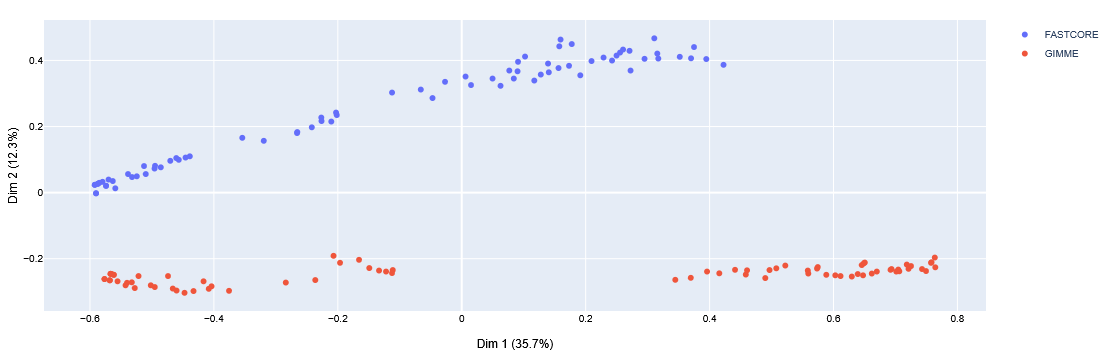

In [50]:
mca = MCA(n_components=3, random_state=42)
data.index = data.index.str.upper()
components = mca.fit_transform(data).to_numpy()
plot(components, [e.split("_")[-2] for e in data.index.tolist()],
    f"Dim 1 ({round(mca.percentage_of_variance_[0], 1)}%)",
    f"Dim 2 ({round(mca.percentage_of_variance_[1], 1)}%)",
    os.path.join(RESULTS_PATH,"mca_models_algorithm_ng"),
    width=1200
)

Top thresholds: ['0.8', '0.6', '0.9', '0.7', '0.65', '0.5', '0.95', '0.85', '0.55', '0.75']


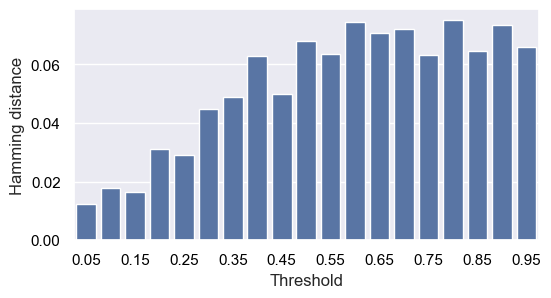

In [7]:
best_thresholds_set = set()
top = 10
dist = rank_models_difference(fastcore)
sorted_thresholds = sorted(dist, key=lambda k: dist[k], reverse=True)
best_thresholds_set.update([float(e) for e in sorted_thresholds[:top]])
print(f"Top thresholds: {sorted_thresholds[:top]}")
fastcore_filtered = fastcore[fastcore.index.str.contains('|'.join([e + "$" for e in sorted_thresholds[:top]]), regex=True)]
plt.figure(figsize=(6, 3)) 
ax = sns.barplot(x=list(dist.keys()), y=list(dist.values()))
xticks = ax.get_xticks()  # Get current x-tick positions
ax.set_xticks(xticks[::2])  # Keep every 2nd tick
ax.set_xticklabels([list(dist.keys())[i] for i in range(len(list(dist.keys()))) if i % 2 == 0])
ax.set(xlabel='Threshold', ylabel='Hamming distance')
ax.tick_params(axis='both', colors='black')
plt.savefig(os.path.join(RESULTS_PATH, "ds_fastcore_barplot.pdf"), format="pdf", bbox_inches='tight', dpi=1200)

Top thresholds: ['0.4', '0.6', '0.8', '0.9', '0.65', '0.7', '0.85', '0.95', '0.5', '0.75']


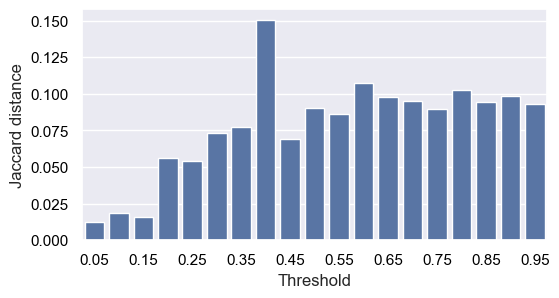

In [3]:
best_thresholds_set = set()
top = 10
dist = rank_models_difference(gimme)
sorted_thresholds = sorted(dist, key=lambda k: dist[k], reverse=True)
best_thresholds_set.update([float(e) for e in sorted_thresholds[:top]])
print(f"Top thresholds: {sorted_thresholds[:top]}")
gimme_filtered = gimme[gimme.index.str.contains('|'.join([e + "$" for e in sorted_thresholds[:top]]), regex=True)]
plt.figure(figsize=(6, 3)) 
ax = sns.barplot(x=list(dist.keys()), y=list(dist.values()))
xticks = ax.get_xticks()  # Get current x-tick positions
ax.set_xticks(xticks[::2])  # Keep every 2nd tick
ax.set_xticklabels([list(dist.keys())[i] for i in range(len(list(dist.keys()))) if i % 2 == 0])
ax.set(xlabel='Threshold', ylabel='Jaccard distance')
ax.tick_params(axis='both', colors='black')
plt.savefig(os.path.join(RESULTS_PATH, "ds_gimme_barplot.pdf"), format="pdf", bbox_inches='tight', dpi=1200)

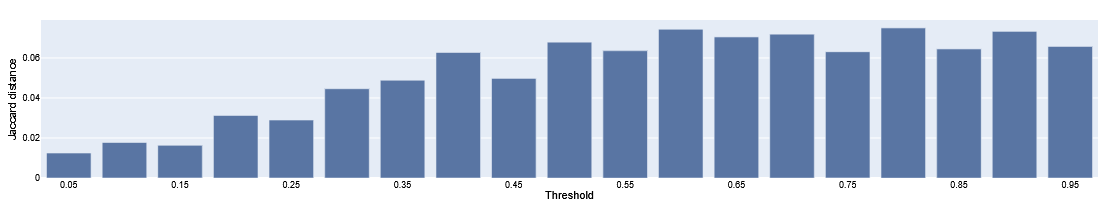

In [35]:
import plotly.express as px
import os

dist = rank_models_difference(fastcore)
# Example data
dist_keys = list(dist.keys())
dist_values = list(dist.values())

bar_color = '#5975A3'
# Create a bar plot
fig = px.bar(
    x=dist_keys, 
    y=dist_values, 
    labels={'x': 'Threshold', 'y': 'Jaccard distance'},  # Axis labels
)
fig.update_traces(marker_color=bar_color)
# Customize the layout
fig.update_layout(
    xaxis=dict(
        tickmode='array', 
        tickvals=dist_keys[::2],  # Show every 2nd tick
        ticktext=[dist_keys[i] for i in range(len(dist_keys)) if i % 2 == 0],
        color='black'
        , title_standoff=1# X-axis ticks color
    ),
    yaxis=dict(color='black', title_standoff=2),  # Y-axis ticks color
    margin=dict(l=20, r=20, t=20, b=20),  # Tight margins
    width=3.5*96,
    height=2.2*96
)
fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20), 
        font=dict(size=9, family="Arial"),
        xaxis=dict(color="black"),  # Set x-axis color to black
        yaxis=dict(color="black")
    )

# Save the figure
fig.write_image(os.path.join(RESULTS_PATH, "ds_stress_fastcore_barplot.pdf"), format="pdf", scale=1)

# Show the plot
fig.show()

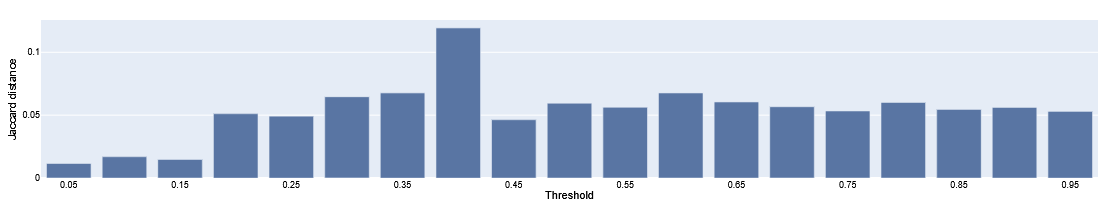

In [36]:
import plotly.express as px
import os

dist = rank_models_difference(gimme)
# Example data
dist_keys = list(dist.keys())
dist_values = list(dist.values())

bar_color = '#5975A3'
# Create a bar plot
fig = px.bar(
    x=dist_keys, 
    y=dist_values, 
    labels={'x': 'Threshold', 'y': 'Jaccard distance'},  # Axis labels
)
fig.update_traces(marker_color=bar_color)
# Customize the layout
fig.update_layout(
    xaxis=dict(
        tickmode='array', 
        tickvals=dist_keys[::2],  # Show every 2nd tick
        ticktext=[dist_keys[i] for i in range(len(dist_keys)) if i % 2 == 0],
        color='black'
        , title_standoff=1# X-axis ticks color
    ),
    yaxis=dict(color='black', title_standoff=2),  # Y-axis ticks color
    margin=dict(l=20, r=20, t=20, b=20),  # Tight margins
    width=3.5*96,
    height=2.2*96
)
fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20), 
        font=dict(size=9, family="Arial"),
        xaxis=dict(color="black"),  # Set x-axis color to black
        yaxis=dict(color="black")
    )

# Save the figure
fig.write_image(os.path.join(RESULTS_PATH, "ds_stress_gimme_barplot.pdf"), format="pdf", scale=1)

# Show the plot
fig.show()

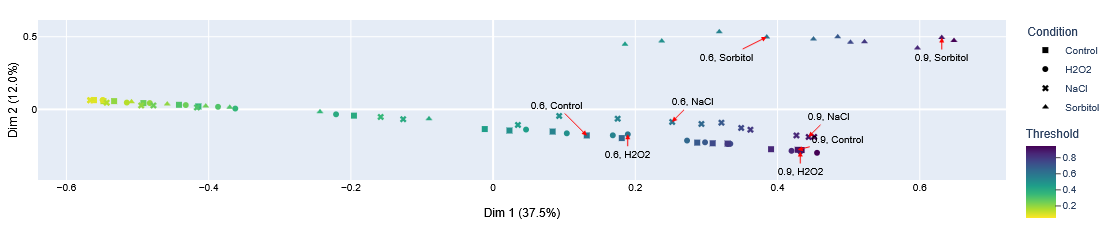

In [33]:
indexes = fastcore.index.tolist()
index_of_interest = [indexes.index(e) for e in indexes if e.endswith("0.9") or e.endswith("0.6")]

mca = MCA(n_components=4, random_state=42)
components = mca.fit_transform(fastcore).to_numpy()

def plot(components, y, xaxis_title, yaxis_title, filename, legend_title="", additional_shapes=None, annotations=None, color=None,
         width=600, height=360, **kwargs):
    if not additional_shapes:
        additional_shapes = []
    if not annotations:
        annotations = []
    if not color:
        color = y
    fig = px.scatter(x=components[:, 0], y=components[:, 1], color=color, **kwargs)
    fig.update_layout(
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        margin=dict(l=20, r=20, t=20, b=20), 
        font=dict(size=10, family="Arial"),
        xaxis=dict(color="black"),  # Set x-axis color to black
        yaxis=dict(color="black", title_standoff=2),
        # xaxis_range = [-0.1, 0.75]
    )
    fig.update_layout(legend_title_text=legend_title, width=width, height=height)
    fig.update_layout(coloraxis_colorbar=dict(title='Threshold', yanchor="top", y=0.4, x=1.01, ticks="outside", len=0.7))
    for shape in additional_shapes:
        fig.add_shape(
            shape
        )
    for ann in annotations:
        fig.add_annotation(
            ann
        )
    fig.show()
    fig.write_image(f"{filename}.pdf", format="pdf", scale=1)

symbol_list = [e.split("_")[0].replace("nacl", "NaCl").replace("h2o2", "H2O2").replace("control", "Control").replace("sorb", "Sorbitol") for e in fastcore.index.tolist()]

symbols = ['square', 'circle', 'x', 'triangle-up']


annotations=[]
for ind in index_of_interest:
    if indexes[ind].split('_')[0].endswith("sorb") and indexes[ind].split('_')[-1] == "0.6":
        x = -40 
        y = 20
    elif indexes[ind].split('_')[0].endswith("sorb") and indexes[ind].split('_')[-1] == "0.9":
        x = 0
        y = 20
    elif indexes[ind].split('_')[0].endswith("o2"): 
        x = 0 
        y = 20
    elif indexes[ind].split('_')[0].endswith("cl"): 
        x = 20 
        y = -20
    elif indexes[ind].split('_')[0] == "control" and indexes[ind].split('_')[-1] == "0.9": 
        x = 40 
        y = -10
    elif indexes[ind].split('_')[0] == "control" and indexes[ind].split('_')[-1] == "0.6": 
        x = -30 
        y = -30
    else:
        x = -20 
        y = -20
    annotations.append(dict(
        x=components[ind, 0],  # Replace `specific_index` with the index of the point
        y=components[ind, 1],  # Replace `specific_index` with the index of the point
        text=f"{indexes[ind].split('_')[-1]}, {indexes[ind].split('_')[0].replace('nacl', 'NaCl').replace('h2o2', 'H2O2').replace('control', 'Control').replace('sorb', 'Sorbitol')}",     # The text you want to display
        showarrow=True,                  # Add an arrow pointing to the point
        arrowhead=2,                     # Arrowhead style
        arrowsize=1,                     # Size of the arrow
        arrowcolor="red",                # Color of the arrow
        ax=x,                           # Offset for the arrow tail in x-direction
        ay=y,                          # Offset for the arrow tail in y-direction
        font=dict(size=10, color="black")
    ))


plot(components, list(float(e.split("_")[-1]) for e in fastcore.index.tolist()),
    f"Dim 1 ({round(mca.percentage_of_variance_[0],1)}%)",
    f"Dim 2 ({round(mca.percentage_of_variance_[1],1)}%)",
    os.path.join(RESULTS_PATH,"ds_stress_mca_fastcore_full"),
    "Condition",
    annotations=annotations,
    symbol = symbol_list, symbol_sequence=symbols,
    color_continuous_scale=px.colors.sequential.Viridis_r,
    width=4*96,
    height=2.5*96
# width=1000
)

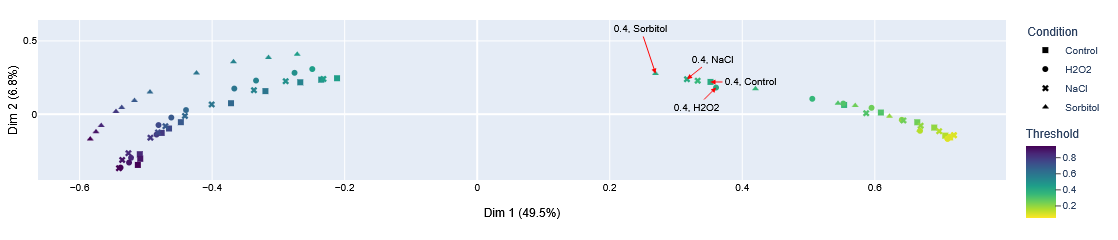

In [38]:
mca = MCA(n_components=3, random_state=42)
components = mca.fit_transform(gimme).to_numpy()

indexes = gimme.index.tolist()
index_of_interest = [indexes.index(e) for e in indexes if e.endswith("0.4")]

def plot(components, y, xaxis_title, yaxis_title, filename, legend_title="", additional_shapes=None, annotations=None, color=None,
         width=600, height=360, **kwargs):
    if not additional_shapes:
        additional_shapes = []
    if not annotations:
        annotations = []
    if not color:
        color = y
    fig = px.scatter(x=components[:, 0], y=components[:, 1], color=color, **kwargs)
    fig.update_layout(
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        margin=dict(l=20, r=20, t=20, b=20), 
        font=dict(size=10, family="Arial"),
        xaxis=dict(color="black"),  # Set x-axis color to black
        yaxis=dict(color="black", title_standoff=2)
    )
    fig.update_layout(legend_title_text=legend_title, width=width, height=height)
    fig.update_layout(coloraxis_colorbar=dict(title='Threshold', yanchor="top", y=0.4, x=1.01, ticks="outside", len=0.7))
    for shape in additional_shapes:
        fig.add_shape(
            shape
        )
    for ann in annotations:
        fig.add_annotation(
            ann
        )
    fig.show()
    fig.write_image(f"{filename}.pdf", format="pdf", scale=1)

symbol_list = [e.split("_")[0].replace("nacl", "NaCl").replace("h2o2", "H2O2").replace("control", "Control").replace("sorb", "Sorbitol") for e in gimme.index.tolist()]
symbols = ['square', 'circle', 'x', 'triangle-up']


annotations=[]
for ind in index_of_interest:
    if indexes[ind].split('_')[0].endswith("sorb"):
        x = -15 
        y = -45
    elif indexes[ind].split('_')[0].endswith("o2"): 
        x = -20 
        y = 20
    elif indexes[ind].split('_')[0].endswith("cl"): 
        x = 25 
        y = -20
    else:
        x = 40 
        y = 0
    annotations.append(dict(
        x=components[ind, 0],  # Replace `specific_index` with the index of the point
        y=components[ind, 1],  # Replace `specific_index` with the index of the point
        text=f"{indexes[ind].split('_')[-1]}, {indexes[ind].split('_')[0].replace('nacl', 'NaCl').replace('h2o2', 'H2O2').replace('control', 'Control').replace('sorb', 'Sorbitol')}",     # The text you want to display
        showarrow=True,                  # Add an arrow pointing to the point
        arrowhead=2,                     # Arrowhead style
        arrowsize=1,                     # Size of the arrow
        arrowcolor="red",                # Color of the arrow
        ax=x,                           # Offset for the arrow tail in x-direction
        ay=y,                          # Offset for the arrow tail in y-direction
        font=dict(size=10, color="black")
    ))

plot(components, list(float(e.split("_")[-1]) for e in gimme.index.tolist()),
    f"Dim 1 ({round(mca.percentage_of_variance_[0],1)}%)",
    f"Dim 2 ({round(mca.percentage_of_variance_[1],1)}%)",
    os.path.join(RESULTS_PATH,"ds_stress_mca_gimme_full"),
    "Condition",
    annotations=annotations,
    symbol = symbol_list, symbol_sequence=symbols,
    color_continuous_scale=px.colors.sequential.Viridis_r,
    width=4*96,
    height=2.5*96
    # width=1000
)